In [1]:
import sys                       
sys.path.append('../scripts/')
from robot import *
from scipy.stats import uniform, norm

In [2]:
class RandomRobot(Robot): ###add_kidnapped### noise, bias, stuckメソッドは省略で
        
    def __init__(self, pose, agent=None, sensor=None, color="black", \
                           noise_prob=0.1, noise_stderr=math.pi/60, bias_rates=(0.1,0.1), \
                           stuck_prob = 0.0, stuck_escape_prob = 1.0, \
                           kidnap_prob = 0.0, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        self.noise_prob = noise_prob
        self.noise_stderr = noise_stderr
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rates[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rates[1]) 
        
        self.stuck_prob = stuck_prob
        self.stuck_escape_prob = stuck_escape_prob
        self.is_stuck = False
        
        self.kidnap_prob = kidnap_prob #以下追加
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
    def noise(self):
        t_noise = 0.0
        
        if uniform.rvs() < self.noise_prob:   
            t_noise = norm.rvs(scale=self.noise_stderr) 

        return np.array([0.0, 0.0, t_noise])
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega):
        if self.is_stuck:
            self.is_stuck = uniform.rvs() >= self.stuck_escape_prob
        else:
            self.is_stuck = uniform.rvs() < self.stuck_prob

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose): #追加
        if uniform.rvs() < self.kidnap_prob: 
            return self.kidnap_dist.rvs()
        else:
            return pose
            
    def one_step(self, time_interval):
        if not self.agent: return
        nu, omega = self.agent.decision()
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega)
        self.pose = self.func_state_transition(nu, omega, time_interval, self.pose) + self.noise()
        self.pose = self.kidnap(self.pose)  #追加
        if self.sensor: self.sensor.data(self.pose)

<IPython.core.display.Javascript object>


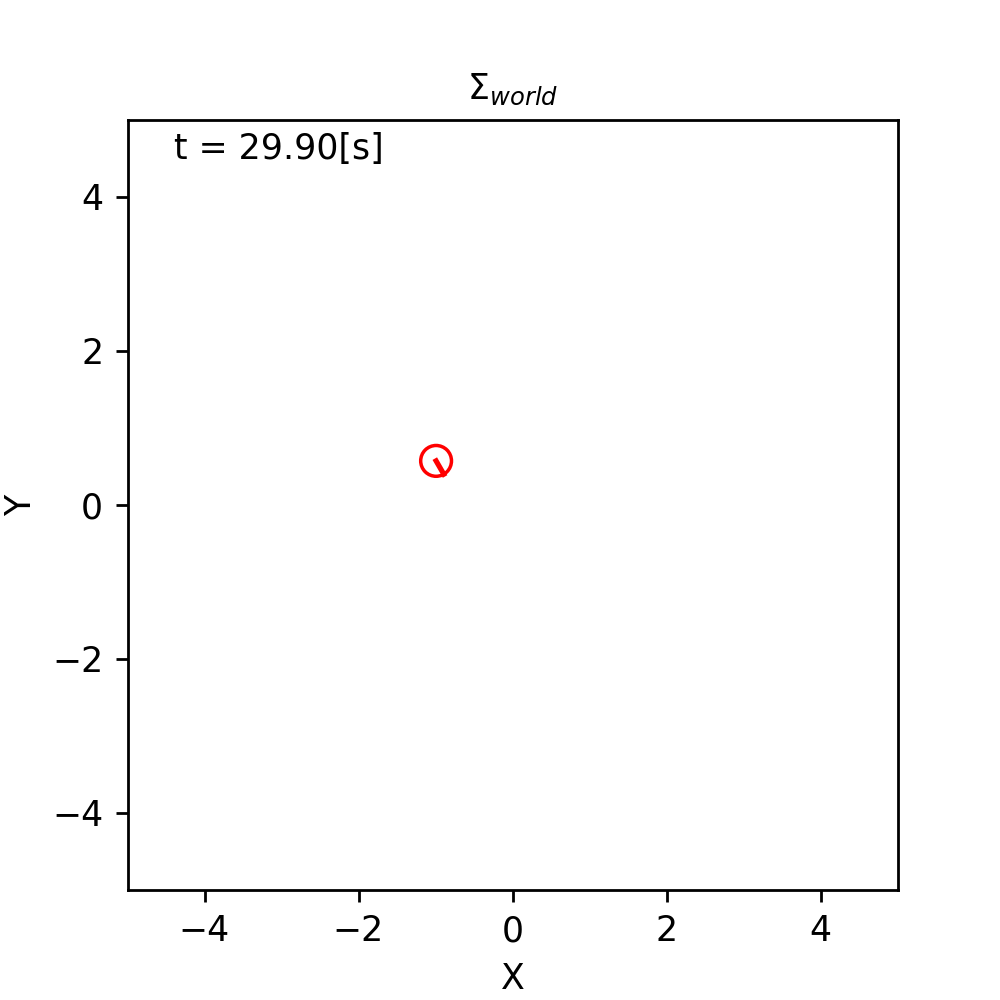

In [3]:
world = World(30, 0.1)           ###kidnap_simulation###

circling = Agent(0.2, 10.0/180*math.pi)

for i in range(1):
    r = RandomRobot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="gray", \
                   noise_prob=0.0, bias_rates=(0.0,0.0), kidnap_prob = 0.01) 
    world.append(r)

r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" ) 
world.append(r)

world.draw()